In [1]:
import json

with open('/storage/datasets/thiago.poppe/HookTheory/sheetsage_raw.json', 'r') as fp:
    raw = json.load(fp)
    
with open('/storage/datasets/thiago.poppe/HookTheory/sheetsage_processed.json', 'r') as fp:
    processed = json.load(fp)

print('Total number of raw data:', len(raw))
print('Total number of processed data:', len(processed))

Total number of raw data: 26178
Total number of processed data: 26175


Fazendo com que ambos dados possuam os mesmos ids.

In [2]:
common_ids = set(raw.keys()) & set(processed.keys())

raw = {key: raw[key] for key in common_ids}
processed = {key: processed[key] for key in common_ids}

print('Total number of raw data:', len(raw))
print('Total number of processed data:', len(processed))

Total number of raw data: 26175
Total number of processed data: 26175


## Filtrando músicas com áudio, harmonia e bem comportadas

> Músicas bem comportadas serão aquelas que não possuem mudanças de ritmo.
>
> Iremos trabalhar apenas com músicas que seguem o formato métrico 4/4 e que possuem apenas escalas maiores e menores. Além de músicas que possuem empréstimos de acordes das escalas: modos gregos, menor harmônica e frígio dominante.

In [3]:
def is_workable(song_id):
    possible_borrowing = [None, '', 'major', 'dorian', 'phrygian', 'lydian',
                          'mixolydian', 'minor', 'locrian', 'harmonicMinor', 'phrygianDominant']

    for tag in ['METER_CHANGES', 'SWING_CHANGES', 'TEMPO_CHANGES']:
        if tag in processed[song_id]['tags']:
            return False

    for tag in ['NO_SWING', 'AUDIO_AVAILABLE', 'HARMONY']:
        if tag not in processed[song_id]['tags']:
            return False

    meter = processed[song_id]['annotations']['meters'][0]
    if meter['beats_per_bar'] != 4 or meter['beat_unit'] != 4:
        return False

    for key in raw[song_id]['json']['keys']:
        if key['scale'] not in ('minor', 'major'):
            return False

    for chord in raw[song_id]['json']['chords']:
        if chord['borrowed'] not in possible_borrowing:
            return False
    
    return True

workable_ids = set()
for song_id, song in processed.items():
    if is_workable(song_id):
        workable_ids.add(song_id)

print('Total number of songs:', len(processed))
print('Number of workable song excerpts:', len(workable_ids))

Total number of songs: 26175
Number of workable song excerpts: 16346


In [4]:
raw = {key: raw[key] for key in workable_ids}
processed = {key: processed[key] for key in workable_ids}

Antes de prosseguirmos, iremos processar a lista de tons de cada música, criando um **onset** e **offset** para cada tonalidade.

In [5]:
song_id = 'Rzoj_DaMmDe'  # apenas um song_id de exemplo para vermos a construção das tonalidades

print('Número total de batidas da música:', processed[song_id]['annotations']['num_beats'])

print('\nTonalidades da música cruas:')
for key in raw[song_id]['json']['keys']:
    print(f' - {key}')

print('\nTonalidades da música processadas:')
for key in processed[song_id]['annotations']['keys']:
    print(f' - {key}')

Número total de batidas da música: 72

Tonalidades da música cruas:
 - {'beat': 1, 'scale': 'major', 'tonic': 'A'}
 - {'beat': 33, 'scale': 'major', 'tonic': 'C'}

Tonalidades da música processadas:
 - {'beat': 0, 'tonic_pitch_class': 9, 'scale_degree_intervals': [2, 2, 1, 2, 2, 2]}
 - {'beat': 32, 'tonic_pitch_class': 0, 'scale_degree_intervals': [2, 2, 1, 2, 2, 2]}


In [6]:
for song_id in processed.keys():
    new_keys = []
    raw_keys = raw[song_id]['json']['keys']
    processed_keys = processed[song_id]['annotations']['keys']
    
    for i in range(len(processed_keys) - 1):
        new_keys.append({
            'onset': processed_keys[i]['beat'],
            'offset': processed_keys[i-1]['beat'],
            'mode': raw_keys[i]['scale'],
            'tonic': raw_keys[i]['tonic'],
            'tonic_pitch_class': processed_keys[i]['tonic_pitch_class'],
        })
        
    # Processando a última tonalidade separadamente
    new_keys.append({
        'onset': processed_keys[-1]['beat'],
        'offset': processed[song_id]['annotations']['num_beats'],
        'mode': raw_keys[-1]['scale'],
        'tonic': raw_keys[-1]['tonic'],
        'tonic_pitch_class': processed_keys[-1]['tonic_pitch_class'],
    })

    processed[song_id]['annotations']['keys'] = new_keys

In [7]:
song_id = 'Rzoj_DaMmDe'  # apenas um song_id de exemplo para vermos a construção das tonalidades

print('Número total de batidas da música:', processed[song_id]['annotations']['num_beats'])

print('\nTonalidades da música:')
for key in processed[song_id]['annotations']['keys']:
    print(f' - {key}')

Número total de batidas da música: 72

Tonalidades da música:
 - {'onset': 0, 'offset': 32, 'mode': 'major', 'tonic': 'A', 'tonic_pitch_class': 9}
 - {'onset': 32, 'offset': 72, 'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}


## Filtrando apenas músicas dos *The Beatles*

In [8]:
def get_artist(song):
    return song['hooktheory']['artist']

beatles_ids = set()
for song_id, song in processed.items():
    artist = get_artist(song)

    if artist == 'the-beatles':
        beatles_ids.add(song_id)

print('Number of The Beatles song excerpts:', len(beatles_ids))

Number of The Beatles song excerpts: 169


In [9]:
raw = {key: raw[key] for key in beatles_ids}
processed = {key: processed[key] for key in beatles_ids}

### Verificando o tempo médio dos trechos das músicas

In [10]:
import numpy as np

def get_song_alignment_times(processed_song):
    alignment = 'refined' if 'REFINED_ALIGNMENT' in processed_song['tags'] else 'user'
    start = processed_song['alignment'][alignment]['times'][0]
    end = processed_song['alignment'][alignment]['times'][-1]

    return start, end

durations = []
for song in processed.values():
    start, end = get_song_alignment_times(song)
    durations.append(end - start)

print(f'Excerpt mean duration (in seconds): {np.mean(durations):.2f}')
print(f'Excerpt standard deviation (in seconds): {np.std(durations, ddof=1):.2f}')

Excerpt mean duration (in seconds): 18.52
Excerpt standard deviation (in seconds): 8.98


## Olhando as informações de ambos dicionários

> Para uma análise melhor, iremos focar em um acorde que possui `applied` (*tonicization*).

In [11]:
song_id = 'VMgJOneyxqK'
processed[song_id]['annotations']['keys']

[{'onset': 0,
  'offset': 20,
  'mode': 'major',
  'tonic': 'F',
  'tonic_pitch_class': 5}]

In [12]:
from music21.scale import MajorScale, ChromaticScale

print('F major scale:  ', [p.name for p in MajorScale('F').getPitches()][:-1])
print('Chromatic scale:', [p.name for p in ChromaticScale('C').getPitches()][:-1])

F major scale:   ['F', 'G', 'A', 'B-', 'C', 'D', 'E']
Chromatic scale: ['C', 'C#', 'D', 'E-', 'E', 'F', 'F#', 'G', 'A-', 'A', 'B-', 'B']


In [13]:
print('Processed root pitch classes:', [chord['root_pitch_class'] for chord in processed[song_id]['annotations']['harmony']])
print('Raw root and applied classes:', [(chord['root'], chord['applied']) for chord in raw[song_id]['json']['chords']])

Processed root pitch classes: [0, 5, 0, 2]
Raw root and applied classes: [(5, 0), (1, 0), (5, 0), (2, 5)]


- Para a música `VMgJOneyxqK` ([Sgt. Pepper's](https://hookpad.hooktheory.com/?idOfSong=VMgJOneyxqK)), temos a seguinte progressão: $\mathbf{V}^7 - \mathbf{I} - \mathbf{V}^7 - 
\mathbf{V}^7/\mathbf{ii}$, traduzindo nos acordes: $\mathbf{C}^7 - \mathbf{F} - \mathbf{C}^7 - \mathbf{D}^7$, lembrando que estamos no tom de **Fá maior**.

> **Importante:** Podemos perceber então que a anotação crua possui a seguinte sintaxe: `tonicization/degree`, onde `degree` é obtido a partir da escala de Fá maior (indexando a partir de 1). Já a anotação processada, descarta a parte de tonificação e decodifica a fundamental do acorde obtido a partir da escala cromática começando de dó (indexando a partir de 0).

In [14]:
print('Raw chords:')
for chord in raw[song_id]['json']['chords']:
    print(chord)

print('\nProcessed chords:')
for chord in processed[song_id]['annotations']['harmony']:
    print(chord)

Raw chords:
{'root': 5, 'beat': 1, 'duration': 4, 'type': 7, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 1, 'beat': 5, 'duration': 4, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 5, 'beat': 9, 'duration': 4, 'type': 7, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 2, 'beat': 13, 'duration': 8, 'type': 7, 'inversion': 0, 'applied': 5, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}

Processed chords:
{'onset': 0, 'offset': 4, 'root_pitc

> **Importante:** Note que os acordes processados apenas focam na fundamental do acorde (após a aplicação da tonificação), na inversão (que é a mesma que o dado cru) e na qualidade do acorde traduzida como semitons, onde por exemplo: `[4, 3]` representa um acorde maior (intervalos de terça maior e terça menor) e `[4, 3, 3]` um acorde maior com sétima menor (intervalos de terça maior, terça menor e terça menor). Sendo assim, podemos obter uma qualidade refinada (observar todos os intervalos) ou uma qualidade superficial (observar os 2 ou 3 primeiros intervalos).

Para a música `JkmZYerZoqn` ([Let It Be](https://hookpad.hooktheory.com/?idOfSong=JkmZYerZoqn)), percebemos que temos empréstimos modais ao longo da música. O tom da música é Dó maior, porém temos a presença de um acorde $\flat \text{VII}$, ou $\text{B}\flat$, que não faz parte da escala de Dó maior, mas sim da escala de Dó menor, bem como da escala de Dó mixolídio e Dó dórico. A anotação foi feita realizando um empréstimo de Dó menor, mas isso não é um problema, já que em todas as escalas citadas anteriormente teremos um $\flat\text{VII}$.

- Apenas por curiosidade, temos as 3 escalas abaixo (tomando como referência a escala de dó maior):
    - **Dó maior**: $\text{I}-\text{ii}-\text{iii}-\text{IV}-\text{V}-\text{vi}-\textcolor{red}{\text{vii}\degree} \rightarrow \text{C}-\text{Dm}-\text{Em}-\text{F}-\text{G}-\text{Am}-\textcolor{red}{\text{B}\degree}$
       
    - **Dó menor**: $\text{i}-\text{ii}\degree-\flat\text{III}-\text{iv}-\text{v}-\flat\text{VI}-\textcolor{lightgreen}{\flat\text{VII}} \rightarrow \text{Cm}-\text{D}\degree-\text{E}\flat-\text{Fm}-\text{Gm}-\text{A}\flat-\textcolor{lightgreen}{\text{B}\flat}$
       
    - **Dó dórico**: $\text{i}-\text{ii}-\flat\text{III}-\text{IV}-\text{v}-\text{vi}\degree-\textcolor{lightgreen}{\flat\text{VII}} \rightarrow \text{Cm}-\text{Dm}-\text{E}\flat-\text{F}-\text{Gm}-\text{A}\degree-\textcolor{lightgreen}{\text{B}\flat}$
       
    - **Dó mixolídio**: $\text{I}-\text{ii}-\text{iii}\degree-\text{IV}-\text{v}-\text{vi}-\textcolor{lightgreen}{\flat\text{VII}} \rightarrow \text{C}-\text{Dm}-\text{E}\degree-\text{F}-\text{Gm}-\text{Am}-\textcolor{lightgreen}{\text{B}\flat}$


> **Importante:** o empréstimo vai apenas dizer se aquele grau é $\sharp$ ou $\flat$.

In [15]:
song_id = 'JkmZYerZoqn'
processed[song_id]['annotations']['keys']

[{'onset': 0,
  'offset': 16,
  'mode': 'major',
  'tonic': 'C',
  'tonic_pitch_class': 0}]

In [16]:
print('Raw chords:')
for chord in raw[song_id]['json']['chords']:
    print(chord)

print('\nProcessed chords:')
for chord in processed[song_id]['annotations']['harmony']:
    print(chord)

Raw chords:
{'root': 4, 'beat': 1, 'duration': 2, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 3, 'beat': 3, 'duration': 1, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 2, 'beat': 4, 'duration': 1, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 1, 'beat': 5, 'duration': 2, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
{'root': 7, 'beat': 7, 'duration': 1, 'type': 5, 'invers

### Criação de estrutura auxiliar para recuperar os acidentes do empréstimo

In [17]:
borrowed_accidentals = {
    'major': {
        'major': ['', '', '', '', '', '', ''],
        'dorian': ['', '', 'b', '', '', '', 'b'],
        'phrygian': ['', 'b', 'b', '', '', 'b', 'b'],
        'lydian': ['', '', '', '#', '', '', ''],
        'mixolydian': ['', '', '', '', '', '', 'b'],
        'minor': ['', '', 'b', '', '', 'b', 'b'],
        'locrian': ['', 'b', 'b', '', 'b', 'b', 'b'],
        'harmonicMinor': ['', '', 'b', '', '', 'b', ''],
        'phrygianDominant': ['', 'b', '', '', '', 'b', 'b']
    },
    'minor': {
        'major': ['', '', '#', '', '', '#', '#'],
        'dorian': ['', '', '', '', '', '#', ''],
        'phrygian': ['', 'b', '', '', '', '', ''],
        'lydian': ['', '', '#', '#', '', '#', '#'],
        'mixolydian': ['', '', '#', '', '', '#', ''],
        'minor': ['', '', '', '', '', '', ''],
        'locrian': ['', 'b', '', '', 'b', '', ''],
        'harmonicMinor': ['', '', '', '', '', '', '#'],
        'phrygianDominant': ['', 'b', '#', '', '', '', '']
    }
}

In [18]:
from music21.scale import MajorScale

db_major_scale = [p.name for p in MajorScale('Db').getPitches()][:-1]
db_major_accidentals = ['' if len(note) == 1 else note[-1].replace('-', 'b') for note in db_major_scale]

print('Db major accidentals:', db_major_accidentals)
print('Harmonic minor borrowed accidentals (on top of existing ones):', borrowed_accidentals['major']['harmonicMinor'])

Db major accidentals: ['b', 'b', '', 'b', 'b', 'b', '']
Harmonic minor borrowed accidentals (on top of existing ones): ['', '', 'b', '', '', 'b', '']


In [19]:
# from music21.scale import (
#     MajorScale, DorianScale, PhrygianScale, LydianScale,
#     MixolydianScale, MinorScale, LocrianScale, HarmonicMinorScale
# )

# from music21.analysis.enharmonics import EnharmonicSimplifier

# def build_scale(tonic, name):
#     scale_mapping = {
#         'major': MajorScale,
#         'dorian': DorianScale,
#         'phrygian': PhrygianScale,
#         'lydian': LydianScale,
#         'mixolydian': MixolydianScale,
#         'minor': MinorScale,
#         'locrian': LocrianScale,
#         'harmonicMinor': HarmonicMinorScale
#     }

#     if name == 'phrygianDominant':  # frígio dominante é o 5º modo da escala menor harmônica
#         scale = [p.name for p in HarmonicMinorScale().deriveByDegree(5, tonic).getPitches()][:-1]
#         scale = np.roll(scale, shift=-4).tolist()
#     else:
#         scale = [p.name for p in scale_mapping[name](tonic).getPitches()][:-1]

#     scale = [p.name for p in EnharmonicSimplifier(scale).bestPitches()]  # resolvendo enarmônicos
#     scale = list(map(lambda p: p.replace('-', 'b'), scale))  # convertendo - para bemól
    
#     return scale

# print('F harmonic minor:   ', build_scale('F', 'harmonicMinor'))
# print('C phrygian dominant:', build_scale('C', 'phrygianDominant'))

In [20]:
# def get_scale_accidentals(scale):
#     return ['' if len(note) == 1 else note[-1] for note in scale]

# def get_borrowed_scale_accidentals_relationship(reference_scale, borrowed_scale):
#     reference_accidentals = get_scale_accidentals(reference_scale)
#     borrowed_accidentals = get_scale_accidentals(borrowed_scale)

#     accidental2value = {'b': -1, '': 0, '#': 1}
#     reference_accidentals = list(map(lambda a: accidental2value[a], reference_accidentals))
#     borrowed_accidentals = list(map(lambda a: accidental2value[a], borrowed_accidentals))

#     value2accidental = {-1: 'b', 0: '', '#': 1}
#     relationship = [value2accidental[a2 - a1] for a1, a2 in zip(reference_accidentals, borrowed_accidentals)]

#     return relationship

# reference = build_scale('Db', 'major')
# borrowed = build_scale('Db', 'locrian')

# print('Db major accidentals:           ', get_scale_accidentals(reference))
# print('Db locrian accidentals:         ', get_scale_accidentals(borrowed))
# print('Scale accidentals relationship:', get_borrowed_scale_accidentals_relationship(reference, borrowed))

In [21]:
# print('F harmonic minor accidentals:   ', get_scale_accidentals(build_scale('F', 'harmonicMinor')))
# print('C phrygian dominant accidentals:', get_scale_accidentals(build_scale('C', 'phrygianDominant')))

### Construíndo um acorde que combina ambos dicionários

Primeiramente iremos observar quais tipos de acorde a gente tem na base de dados.

Podemos usar a flag `simplify_quality`, para usar uma anotação simplificada dos acordes, trabalhando com menos variação de acordes.

In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict

simplify_quality = True

_INTERVALS_TO_QUALITY = {
    (4, 3): "maj",  # Major
    (3, 4): "m",  # Minor
    (3, 4, 3): "m7",  # Minor 7
    (4, 3, 3): "7",  # 7
    (4, 3, 4): "maj7",  # Major 7
    (5, 2): "sus4",  # Sus 4
    (4, 3, 7): "add9",  # Add 9
    (3, 3): "dim",  # Dim
    (3, 3, 4): "m7(b5)",  # Dim minor 7
    (2, 5): "sus2",  # Sus 2
    (5, 2, 3): "7sus4",  # 7 Sus 4
    (3, 4, 3, 4): "m9",  # Minor 9
    (4, 3, 4, 3): "maj9",  # Major 9
    (2, 5, 3): "7sus2",  # 7 Sus 2
    (3, 4, 7): "m(add9)",  # Minor Add 9
    (3, 3, 3): "dim7",  # Dim 7
    (2, 5, 4): "maj7sus2",  # Major 7 Sus 2
    (4, 3, 3, 4): "9",  # 9
    (2, 3, 2): "sus2sus4",  # Sus 2 Sus 4
    (4, 4): "(#5)",  # Aug
}

_INTERVALS_TO_FAMILY = {
    (4, 3): 'maj',
    (3, 4): 'm',
    (3, 4, 3): 'm7',
    (4, 3, 3): '7',
    (4, 3, 4): 'maj7',
    (5, 2): 'sus',
    (3, 3): 'dim',
    (4, 4): 'aug'
}

In [23]:
def get_chord_quality(chord, simplify_quality):
    quality = '<unk>'
    intervals = tuple(chord['root_position_intervals'])
    qualities = _INTERVALS_TO_FAMILY if simplify_quality else _INTERVALS_TO_QUALITY

    if intervals in qualities:
        quality = qualities[intervals]

    return quality


counter = defaultdict(lambda: 0)

for song in processed.values():
    for chord in song['annotations']['harmony']:
        quality = get_chord_quality(chord, simplify_quality)
        counter[quality] += 1

total_counter = sum(counter.values())
counter = {k: 100 * (v / total_counter) for k, v in counter.items()}
counter = {k: v for k, v in sorted(counter.items(), key=lambda p: p[1], reverse=True)}

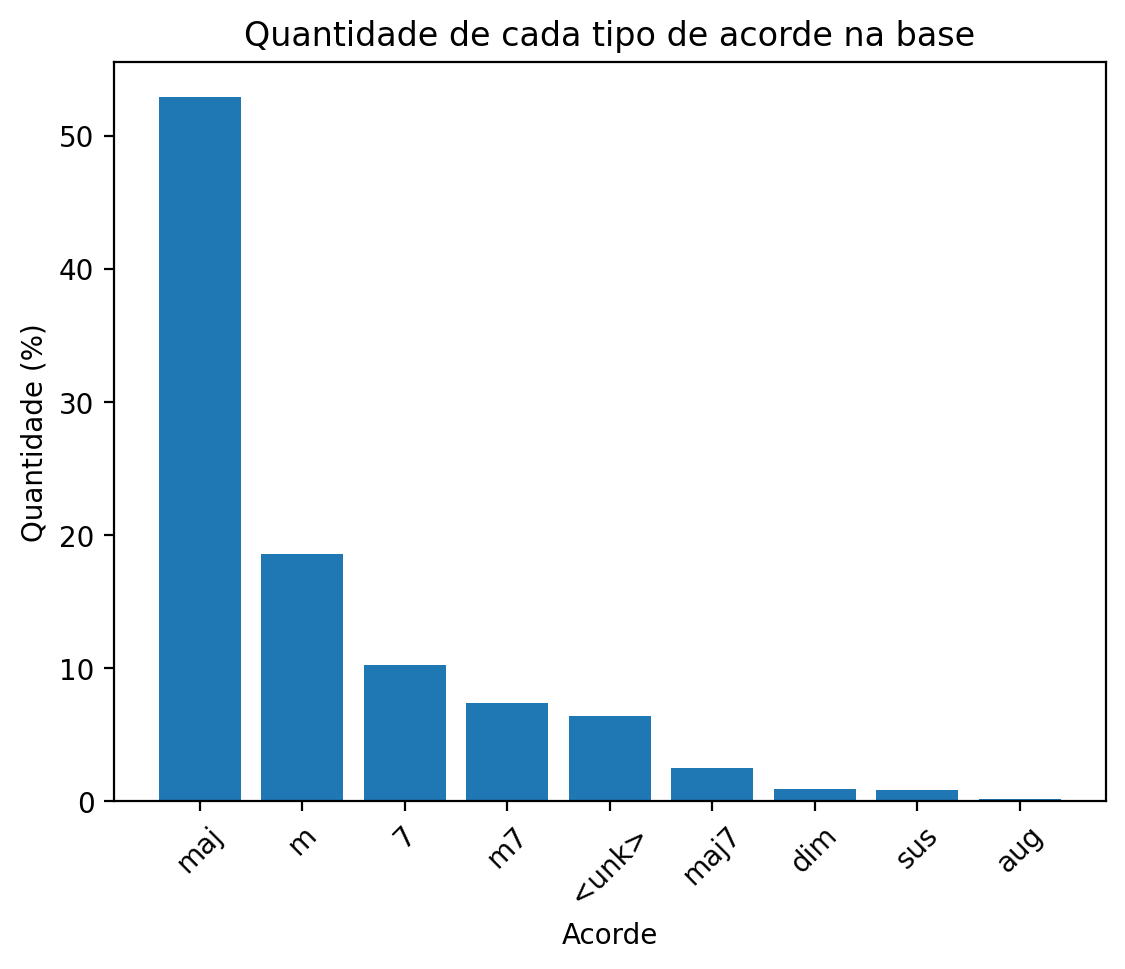

In [24]:
plt.title(f'Quantidade de cada tipo de acorde na base')
plt.bar(range(len(counter)), counter.values())
plt.xticks(range(len(counter)), counter.keys(), rotation=45)

plt.xlabel('Acorde')
plt.ylabel('Quantidade (%)')
plt.show()

Para isso, iremos padronizar um acorde para conter as seguintes informações:
1. `key`: indicando a tonalidade da música naquele momento (trabalharemos com escalas maiores e menores apenas);
2. `tonicization`: indicando o grau secundário do acorde, ou seja, uma mudança temporária no tom da música (também representando em algarismo romano);
3. `degree`: indicando o grau primário do acorde (algarismo romano representando a posição do acorde na escala);
4. `quality`: indicando a qualidade do acorde (maior, menor, dominante, etc);
5. `inversion`: indicando a inversão do acorde (1ª, 2ª, 3ª ou nenhuma);
6. `root`: indicando a fundamental do acorde, representada pela posição da nota na escala cromática.

<br>

> **Importante:** a componente `root` é redudante com as demais, uma vez que dado `key`, `tonicization` e `degree`, nós conseguimos estimar `root` de forma garantida. Porém, isso trará mais consistência durante a predição de algumas redes no futuro.

Antes de construírmos os acordes propriamente ditos, vamos criar uma função para pegar o tom local da música quando aquele acorde é tocado.

In [25]:
processed[song_id]['annotations']['keys']

[{'onset': 0,
  'offset': 16,
  'mode': 'major',
  'tonic': 'C',
  'tonic_pitch_class': 0}]

In [26]:
def get_chord_local_key(processed_chord, processed_keys):
    onset = processed_chord['onset']
    offset = processed_chord['offset']

    for key in processed_keys:
        if onset >= key['onset'] and offset <= key['offset']:
            return {k: key[k] for k in ['mode', 'tonic', 'tonic_pitch_class']}
        
    raise ValueError('Unable to find key for chord')

In [27]:
song_id = 'Rzoj_DaMmDe'  # apenas um song_id de exemplo para vermos a operação da função

for idx, chord in enumerate(processed[song_id]['annotations']['harmony']):
    key = get_chord_local_key(chord, processed[song_id]['annotations']['keys'])
    print(f' Chord {idx}: {key}')

 Chord 0: {'mode': 'major', 'tonic': 'A', 'tonic_pitch_class': 9}
 Chord 1: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 2: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 3: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 4: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 5: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 6: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 7: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 8: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 9: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}
 Chord 10: {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}


In [28]:
def build_chord(raw_chord, processed_chord, processed_keys, simplify_quality):
    root = raw_chord['root']
    key = get_chord_local_key(processed_chord, processed_keys)
    
    # Getting degree accident based on borrowed
    accidental = ''
    if raw_chord['borrowed']:
        accidental = borrowed_accidentals[key['mode']][raw_chord['borrowed']][root-1]

    return {
        'onset': processed_chord['onset'],
        'offset': processed_chord['offset'],
        'key': key,
        'tonicization': raw_chord['applied'],
        'degree': accidental + str(root),
        'quality': get_chord_quality(processed_chord, simplify_quality),
        'inversion': int(processed_chord['inversion']),
        'root_pitch_class': int(processed_chord['root_pitch_class'])
    }

In [29]:
song_id = 'JkmZYerZoqn'  # apenas um song_id de exemplo para vermos a construção das tonalidades

print('Acordes da música (cru):')
for chord in raw[song_id]['json']['chords']:
    print(f' - {chord}')

print('\nAcordes da música (processados):')
for chord in processed[song_id]['annotations']['harmony']:
    print(f' - {chord}')

Acordes da música (cru):
 - {'root': 4, 'beat': 1, 'duration': 2, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
 - {'root': 3, 'beat': 3, 'duration': 1, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
 - {'root': 2, 'beat': 4, 'duration': 1, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
 - {'root': 1, 'beat': 5, 'duration': 2, 'type': 5, 'inversion': 0, 'applied': 0, 'adds': [], 'omits': [], 'alterations': [], 'suspensions': [], 'pedal': None, 'alternate': '', 'borrowed': '', 'isRest': False, 'recordingEndBeat': None}
 - {'root': 7, 'beat': 7, 'dura

In [30]:
for song_id in processed.keys():
    new_chords = []
    raw_chords = raw[song_id]['json']['chords']
    processed_chords = processed[song_id]['annotations']['harmony']
    processed_keys = processed[song_id]['annotations']['keys']
    
    raw_idx = 0
    for processed_chord in processed_chords:
        while raw_chords[raw_idx]['isRest']:
            raw_idx += 1
        
        new_chords.append(build_chord(raw_chords[raw_idx], processed_chord, processed_keys, simplify_quality))
        raw_idx += 1

    processed[song_id]['annotations']['harmony'] = new_chords

In [31]:
song_id = 'JkmZYerZoqn'  # apenas um song_id de exemplo para vermos a construção dos acordes

print('Acordes da música (processados):')
for chord in processed[song_id]['annotations']['harmony']:
    print(f' - {chord}')

Acordes da música (processados):
 - {'onset': 0, 'offset': 2, 'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}, 'tonicization': 0, 'degree': '4', 'quality': 'maj', 'inversion': 0, 'root_pitch_class': 5}
 - {'onset': 2, 'offset': 3, 'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}, 'tonicization': 0, 'degree': '3', 'quality': 'm', 'inversion': 0, 'root_pitch_class': 4}
 - {'onset': 3, 'offset': 4, 'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}, 'tonicization': 0, 'degree': '2', 'quality': 'm', 'inversion': 0, 'root_pitch_class': 2}
 - {'onset': 4, 'offset': 6, 'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}, 'tonicization': 0, 'degree': '1', 'quality': 'maj', 'inversion': 0, 'root_pitch_class': 0}
 - {'onset': 6, 'offset': 7, 'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0}, 'tonicization': 0, 'degree': 'b7', 'quality': 'maj', 'inversion': 0, 'root_pitch_class': 10}
 - {'onset': 7, 'offset': 8, 'key': {'mode': 'maj

## Construção de um json mais limpo

In [32]:
beatles = {}

for song_id in processed.keys():
    raw_song = raw[song_id]
    processed_song = processed[song_id]

    # Definindo dados relacionados com YouTube
    start, end = get_song_alignment_times(processed_song)
    youtube_json = {
        'url': processed_song['youtube']['url'],
        'start': start,
        'end': end
    }
    
    # Definido metadados
    metadata_json = {
        'song': processed_song['hooktheory']['song'],
        'artist': processed_song['hooktheory']['artist'],
        'num_beats': processed_song['annotations']['num_beats'],
        'bpm': raw_song['json']['tempos'][0]['bpm'],  # teremos sempre 1 BPM para a música toda, já que não temos TEMPO_CHANGES
        'simplify_quality': simplify_quality
    }

    beatles[song_id] = {
        'metadata': metadata_json,
        'youtube': youtube_json,
        'harmony': processed_song['annotations']['harmony']
    }

In [33]:
song_id = 'JkmZYerZoqn'  # apenas um song_id de exemplo para vermos a construção do json limpo
beatles[song_id]

{'metadata': {'song': 'let-it-be',
  'artist': 'the-beatles',
  'num_beats': 16,
  'bpm': 138,
  'simplify_quality': True},
 'youtube': {'url': 'https://www.youtube.com/watch?v=QDYfEBY9NM4',
  'start': 105.2555833196328,
  'end': 112.25558331963279},
 'harmony': [{'onset': 0,
   'offset': 2,
   'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0},
   'tonicization': 0,
   'degree': '4',
   'quality': 'maj',
   'inversion': 0,
   'root_pitch_class': 5},
  {'onset': 2,
   'offset': 3,
   'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0},
   'tonicization': 0,
   'degree': '3',
   'quality': 'm',
   'inversion': 0,
   'root_pitch_class': 4},
  {'onset': 3,
   'offset': 4,
   'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0},
   'tonicization': 0,
   'degree': '2',
   'quality': 'm',
   'inversion': 0,
   'root_pitch_class': 2},
  {'onset': 4,
   'offset': 6,
   'key': {'mode': 'major', 'tonic': 'C', 'tonic_pitch_class': 0},
   'tonicization': 0,
   'deg

## Escrita da anotação para uma subdivisão rítmica

> **Importante:** Como uma batida da nossa música **sempre será** da duração de uma semínima ($1$), teremos que as resoluções de $0.5$ e $0.25$ corresponderão à colcheias e semicolcheias.

In [34]:
def resample_harmony(harmony, num_beats, res):
    assert res in [0.25, 0.5, 1], 'Resolution parameter must be either: 0.25 (sixteenth note resolution), ' \
                                  '0.5 (eighth note resolution) or 1 (quarter note resolution)'

    def get_subdict_as_string(d, keys):
        return json.dumps({k: d[k] for k in keys})

    start = 0
    resampled = []
    wanted_keys = ['key', 'tonicization', 'degree', 'quality', 'inversion', 'root_pitch_class']

    for chord in harmony:
        while start + res <= chord['offset']:
            if start < chord['onset']:  # estamos em uma pausa!
                resampled.append('<rest>')
            else:
                resampled.append(get_subdict_as_string(chord, wanted_keys))

            start += res

    # Filling the remaining beats with rests if needed]
    remaning_beats = int(num_beats * (1 / res)) - len(resampled)
    resampled += remaning_beats * ['<rest>']
    
    return resampled

song_id = 'jDgXpWK_gKl'
resampled_harmony = resample_harmony(beatles[song_id]['harmony'],
                                     beatles[song_id]['metadata']['num_beats'],
                                     res=0.5)

print('Original number of beats:', beatles[song_id]['metadata']['num_beats'])
print('Number of beats:', len(resampled_harmony))

Original number of beats: 16
Number of beats: 32


Verificando o método para a música `zngRBjEBgJj` ([Octopus' Garden](https://hookpad.hooktheory.com/?idOfSong=zngRBjEBgJj)), que possui várias pausas nos acordes.

In [35]:
song_id = 'zngRBjEBgJj'
resampled_harmony = resample_harmony(beatles[song_id]['harmony'],
                                     beatles[song_id]['metadata']['num_beats'],
                                     res=0.5)

print('Original number of beats:', beatles[song_id]['metadata']['num_beats'])
print('Number of beats:', len(resampled_harmony))

Original number of beats: 64
Number of beats: 128


In [36]:
resampled_harmony

['<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '{"key": {"mode": "major", "tonic": "E", "tonic_pitch_class": 4}, "tonicization": 0, "degree": "5", "quality": "maj", "inversion": 0, "root_pitch_class": 11}',
 '<rest>',
 '{"key": {"mode": "major", "tonic": "E", "tonic_pitch_class": 4}, "tonicization": 0, "degree": "1", "quality": "maj", "inversion": 0, "root_pitch_class": 4}',
 '{"key": {"mode": "major", "tonic": "E", "tonic_pitch_class": 4}, "tonicization": 0, "degree": "1", "quality": "maj", "inversion": 0, "root_pitch_class": 4}',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '<rest>',
 '{"key": {"mode": "major", "tonic": "E", "tonic_pitch_class": 4}, "tonicization": 0, "degree": "1", "quality": "maj", "inversion": 0, "root_pitch_class": 4}',
 '{"key": {"mode": "major", "tonic": "E", "tonic_pitch_class": 4}, "tonicization": 0, "degree": "5", "quality": "maj"

Processando a harmonia de todas as músicas para a resolução $0.25$ (semicolcheia, ou *sixteenth note*).

In [37]:
res = 0.25

for song_id in beatles.keys():
    harmony = beatles[song_id].pop('harmony')
    beatles[song_id]['metadata']['harmony_res'] = res
    beatles[song_id]['harmony'] = resampled_harmony = resample_harmony(harmony,
                                                                       beatles[song_id]['metadata']['num_beats'],
                                                                       res=res)

Salvando o novo dicionário contendo as anotações e formações pertinentes sobre as músicas dos *The Beatles*.

In [38]:
with open('/storage/datasets/thiago.poppe/beatles/the_beatles.json', 'w') as fp:
    json.dump(beatles, fp, indent=2)